## Scratch notebook for testing

Session: ('samosa', 'S103', 'all_other_t01')


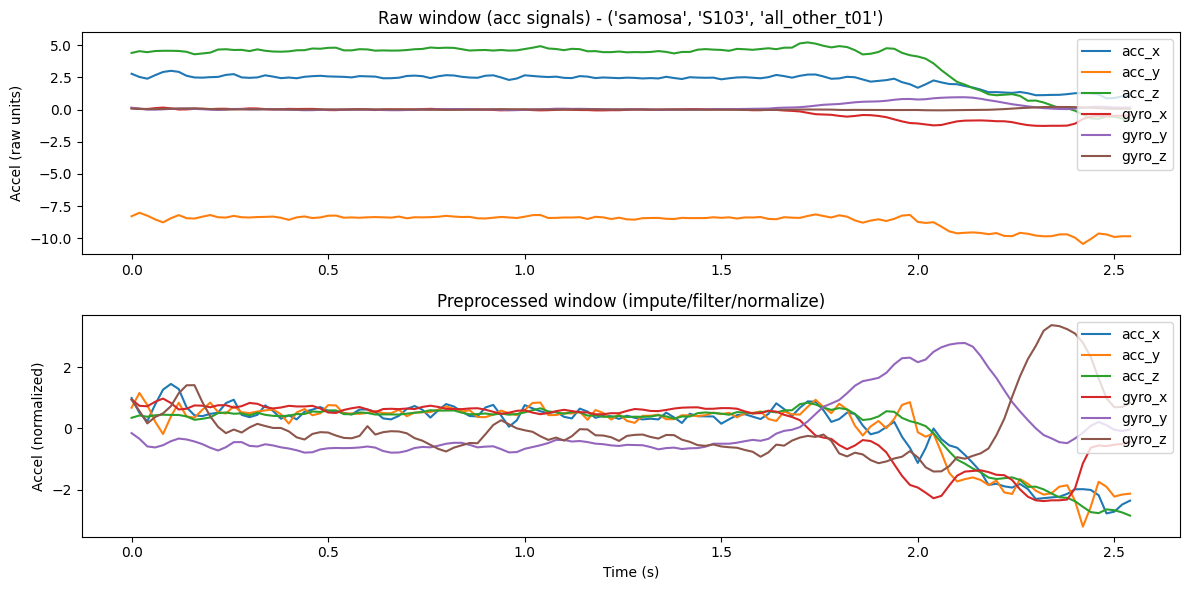

In [1]:
# Visualize one IMU window: raw vs preprocessed (impute/filter/normalize per configs/base.yaml)
# Streams a single session without building the full session index (fast):
# - scan only key columns to pick the first session
# - read just that session via pyarrow filter
# - plot raw vs preprocessed accelerometer signals

import yaml
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds

from imu_lm.data.windowing import compute_T_and_hop
from imu_lm.data.augmentations.preprocess import preprocess_window


def cfg_get(cfg, path, default=None):
    cur = cfg
    for key in path:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(key, default)
        else:
            cur = getattr(cur, key, default)
    return cur if cur is not None else default


# Load base config
cfg = yaml.safe_load(open("configs/base.yaml", "r"))
parquet_path = cfg_get(cfg, ["paths", "dataset_path"])

dataset_col = cfg_get(cfg, ["data", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "session_column"], "session_id")
time_col = cfg_get(cfg, ["data", "time_column"], None)
label_col = cfg_get(cfg, ["data", "label_column"], "dataset_activity_id")
sensor_cols = cfg_get(cfg, ["data", "sensor_columns"], [])

# 1) Find a single session key via lightweight scan (no full index)
#    Optional: set FILTER_DATASET to restrict to a specific dataset (e.g. "samosa" for gyro testing)
FILTER_DATASET = "samosa"  # e.g. "samosa" to pick a session from a gyro-having dataset
pa_ds = ds.dataset(parquet_path, format="parquet")
key_cols = [dataset_col, subject_col, session_col]
scan_filter = ds.field(dataset_col) == FILTER_DATASET if FILTER_DATASET else None
scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000, filter=scan_filter)
key = None
for batch in scanner.to_batches():
    if len(batch) == 0:
        continue
    ds_vals = batch[dataset_col].to_pylist()
    subj_vals = batch[subject_col].to_pylist()
    sess_vals = batch[session_col].to_pylist()
    if ds_vals:
        key = (str(ds_vals[0]), str(subj_vals[0]), str(sess_vals[0]))
        break
assert key is not None, "No sessions found in dataset"
print(f"Session: {key}")

# 2) Stream only that session's rows
cols = list(sensor_cols) + [label_col]
if time_col:
    cols.append(time_col)
cols.extend([dataset_col, subject_col, session_col])

filt = (
    (ds.field(dataset_col) == key[0])
    & (ds.field(subject_col) == key[1])
    & (ds.field(session_col) == key[2])
)
table = pa_ds.to_table(columns=cols, filter=filt)
df = table.to_pandas()

# 3) Take the first window
T, _ = compute_T_and_hop(cfg)
assert len(df) >= T, "Session shorter than one window"
X = df[sensor_cols].to_numpy(dtype=np.float32)
Xw = X[:T]

# 4) Preprocess (impute -> filter -> normalize) → [C, T]
Xproc = preprocess_window(Xw.copy(), cfg)
assert Xproc is not None, "Window was dropped by preprocessing"

# 5) Plot raw vs preprocessed (assumes canonical 50 Hz)
t_raw = np.arange(Xw.shape[0]) / 50.0
t_proc = np.arange(Xproc.shape[1]) / 50.0

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
axes[0].plot(t_raw, Xw)
axes[0].set_title(f"Raw window (acc signals) - {key}")
axes[0].set_ylabel("Accel (raw units)")
axes[0].legend(sensor_cols, loc="upper right")

axes[1].plot(t_proc, Xproc.T)
axes[1].set_title("Preprocessed window (impute/filter/normalize)")
axes[1].set_ylabel("Accel (normalized)")
axes[1].legend(sensor_cols, loc="upper right")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

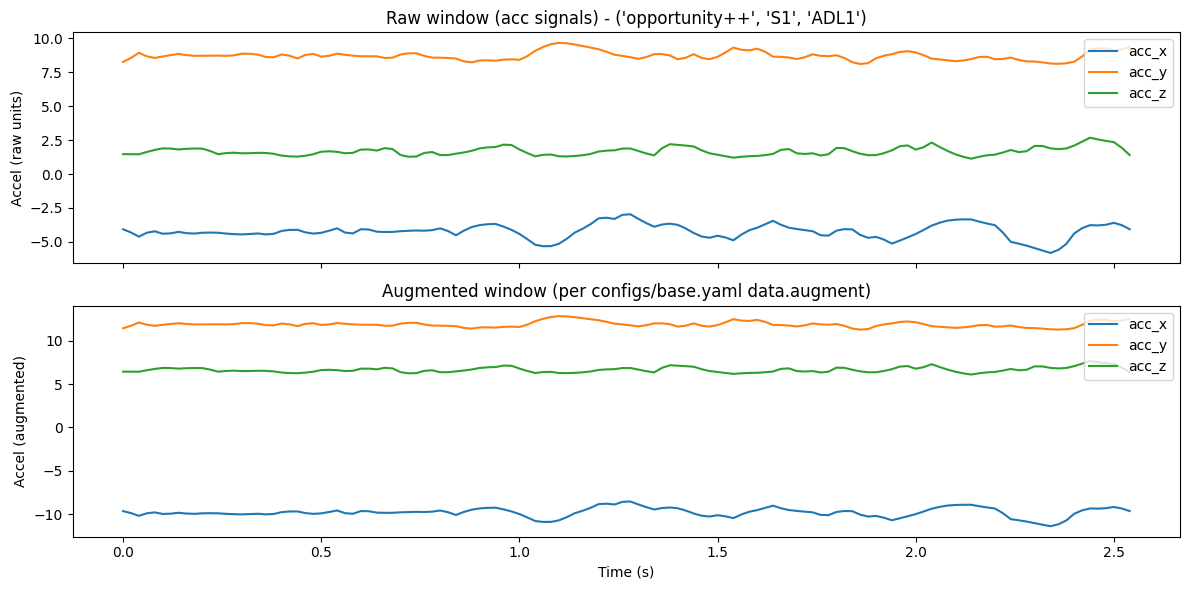

In [18]:
# Visualize raw vs augmented window (uses configs/base.yaml and imu_lm.data.augmentations.transform.apply_augment)
# This is fast: streams a single session and a single window.

import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import yaml

from imu_lm.data.augmentations.transform import apply_augment
from imu_lm.data.windowing import compute_T_and_hop


def cfg_get(cfg, path, default=None):
    cur = cfg
    for key in path:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(key, default)
        else:
            cur = getattr(cur, key, default)
    return cur if cur is not None else default


# Load config and dataset path
cfg = yaml.safe_load(open("configs/base.yaml", "r"))
parquet_path = cfg_get(cfg, ["data", "loading", "dataset_path"])

# Columns
sensor_cols = cfg_get(cfg, ["data", "loading", "sensor_columns"], [])
label_col = cfg_get(cfg, ["data", "loading", "label_column"], "global_activity_id")
time_col = cfg_get(cfg, ["data", "loading", "time_column"], None)
dataset_col = cfg_get(cfg, ["data", "loading", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "loading", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "loading", "session_column"], "session_id")

# Find a session key quickly (scan only key columns)
pa_ds = ds.dataset(parquet_path, format="parquet")
key_cols = [dataset_col, subject_col, session_col]
scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000)
key = None
for batch in scanner.to_batches():
    if len(batch) == 0:
        continue
    ds_vals = batch[dataset_col].to_pylist()
    subj_vals = batch[subject_col].to_pylist()
    sess_vals = batch[session_col].to_pylist()
    if ds_vals:
        key = (str(ds_vals[0]), str(subj_vals[0]), str(sess_vals[0]))
        break
assert key is not None, "No sessions found in dataset"

# Fetch that session's rows (only needed columns)
cols = list(sensor_cols) + [label_col]
if time_col:
    cols.append(time_col)
cols.extend([dataset_col, subject_col, session_col])

filt = (
    (ds.field(dataset_col) == key[0])
    & (ds.field(subject_col) == key[1])
    & (ds.field(session_col) == key[2])
)
table = pa_ds.to_table(columns=cols, filter=filt)
df = table.to_pandas()

# Take first window
T, _ = compute_T_and_hop(cfg)
assert len(df) >= T, "Session shorter than one window"
X = df[sensor_cols].to_numpy(dtype=np.float32)
Xw = X[:T]

# Apply augmentations per config
X_aug = apply_augment(Xw.copy(), cfg)

# Plot
fs = 50.0
tr = np.arange(Xw.shape[0]) / fs
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(tr, Xw)
axes[0].set_title(f"Raw window (acc signals) - {key}")
axes[0].set_ylabel("Accel (raw units)")
axes[0].legend(sensor_cols, loc="upper right")

axes[1].plot(tr, X_aug)
axes[1].set_title("Augmented window (per configs/base.yaml data.augment)")
axes[1].set_ylabel("Accel (augmented)")
axes[1].legend(sensor_cols, loc="upper right")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


Loading weights:   0%|          | 0/334 [00:00<?, ?it/s]

Session: bathroom_brushing_hair_t01 — Brushing_hair
Spectrogram: (3, 65, 65), range [0.0, 1.0], mean 0.2
Model input: (3, 224, 224), range [0.0, 1.0], mean 0.2
log_scale=True


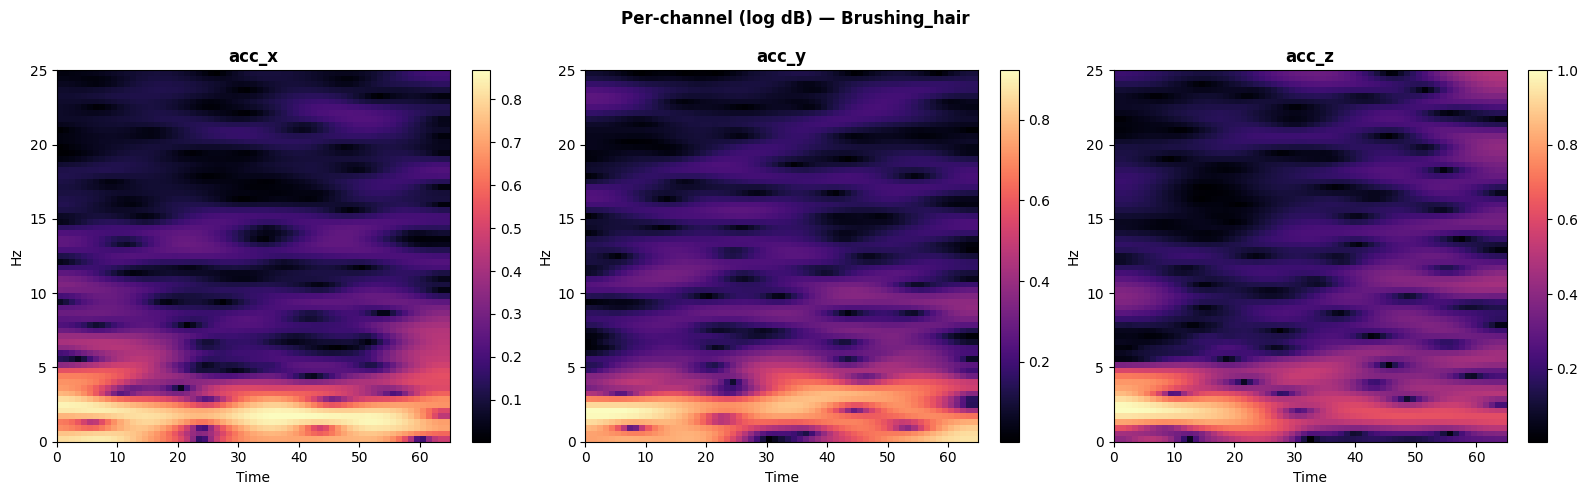

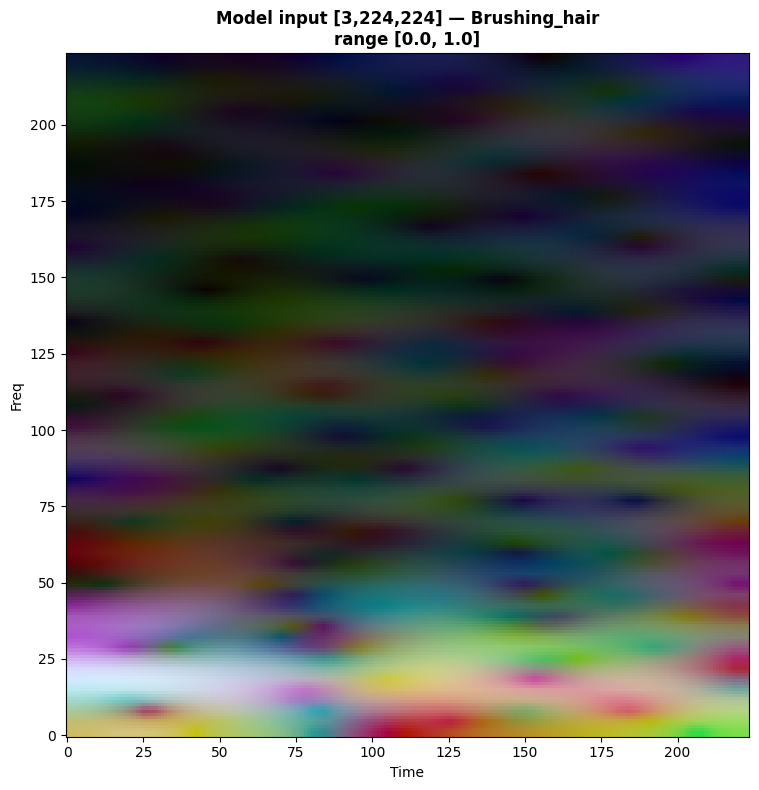

In [3]:
# ViT2D spectrogram pipeline visualization (log dB)
import numpy as np, matplotlib.pyplot as plt, pandas as pd, torch, torch.nn.functional as F
import pyarrow.dataset as ds
from imu_lm.utils.helpers import load_yaml, deep_update, cfg_get
from imu_lm.data.loaders import WindowDataset
from imu_lm.data.splits import SessionKey
from imu_lm.models.ViT2D.model import ViTEncoder

cfg = deep_update(load_yaml("configs/base.yaml"), load_yaml("configs/vit2d.yaml"))
pa = ds.dataset(cfg_get(cfg, ["paths", "dataset_path"]), format="parquet")
dc, sc, sessc = cfg_get(cfg,["data","dataset_column"]), cfg_get(cfg,["data","subject_column"]), cfg_get(cfg,["data","session_column"])

# Pick a non-"other" SAMoSA session
seen, key = set(), None
for b in pa.scanner(columns=[dc,sc,sessc], batch_size=100_000, filter=ds.field(dc)=="samosa").to_batches():
    for d,s,sess in zip(b[dc].to_pylist(), b[sc].to_pylist(), b[sessc].to_pylist()):
        if str(sess) not in seen and "other" not in str(sess).lower():
            key = SessionKey(dataset=str(d), subject_id=str(s), session_id=str(sess)); break
        seen.add(str(sess))
    if key: break

sf = (ds.field(dc)==key.dataset)&(ds.field(sc)==key.subject_id)&(ds.field(sessc)==key.session_id)
row = pa.to_table(columns=["dataset_activity_id","dataset_activity_label"], filter=sf).slice(0,1).to_pandas()
activity = row["dataset_activity_label"].iloc[0]
n_rows = pa.scanner(filter=sf).count_rows()
idx = pd.DataFrame([{"dataset":key.dataset,"subject_id":key.subject_id,"session_id":key.session_id,"n_rows":n_rows,"gap_count":0}])

# Get spectrogram from native pipeline
dataset = WindowDataset(cfg_get(cfg,["paths","dataset_path"]), idx, [key], cfg, split_name="viz")
x, y = dataset[0]  # [3, F, TT]

# Resize to 224x224 (what model sees)
encoder = ViTEncoder(cfg)
x_224 = encoder._prepare(x.unsqueeze(0))[0]  # [3, 224, 224]

print(f"Session: {key.session_id} — {activity}")
print(f"Spectrogram: {tuple(x.shape)}, range [{x.min():.1f}, {x.max():.1f}], mean {x.mean():.1f}")
print(f"Model input: {tuple(x_224.shape)}, range [{x_224.min():.1f}, {x_224.max():.1f}], mean {x_224.mean():.1f}")
print(f"log_scale={cfg_get(cfg,['spectrogram','log_scale'])}")

# Display helper
to01 = lambda t: ((t-t.min())/(t.max()-t.min()+1e-12)).detach().numpy()
ch_names = cfg_get(cfg,["data","sensor_columns"],["Ch0","Ch1","Ch2"])
fs = 50.0
ext = [0, x.shape[2], 0, fs/2]

# Per-channel spectrograms
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for c in range(3):
    im = axes[c].imshow(x[c].numpy(), aspect="auto", origin="lower", cmap="magma", extent=ext)
    axes[c].set_title(ch_names[c], fontweight="bold"); axes[c].set_ylabel("Hz"); axes[c].set_xlabel("Time")
    plt.colorbar(im, ax=axes[c], fraction=0.046)
fig.suptitle(f"Per-channel (log dB) — {activity}", fontweight="bold"); plt.tight_layout(); plt.show()

# Final 224x224 model input
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(to01(x_224).transpose(1,2,0), aspect="equal", origin="lower")
ax.set_title(f"Model input [3,224,224] — {activity}\nrange [{x_224.min():.1f}, {x_224.max():.1f}]", fontweight="bold")
ax.set_ylabel("Freq"); ax.set_xlabel("Time"); plt.tight_layout(); plt.show()

In [7]:
import torch
import torch.nn.functional as F
hf_mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
hf_std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
 
img_resized = F.interpolate(img.unsqueeze(0), size=(224,224), mode="bilinear", align_corners=False).squeeze(0)  # [3,224,224]
img_hf = (img_resized - hf_mean) / hf_std  # normalized
 
# for visualization, unnormalize back to 0-1
vis = (img_hf * hf_std + hf_mean).permute(1,2,0).cpu().numpy()
plt.imshow(vis, aspect="auto", origin="lower"); plt.axis("off"); plt.show()
 
print("img_resized stats:", img_resized.min().item(), img_resized.max().item(), img_resized.mean().item())
print("img_hf stats:", img_hf.min().item(), img_hf.max().item(), img_hf.mean().item())

NameError: name 'img' is not defined

In [7]:
import yaml
import pyarrow.dataset as ds

# load base config
cfg = yaml.safe_load(open("configs/base.yaml"))
parquet_path = cfg["data"]["loading"]["dataset_path"]
dataset_col = cfg["data"]["loading"]["dataset_column"]

print("parquet:", parquet_path)
dset = ds.dataset(parquet_path, format="parquet")

# list dataset names and counts
table = dset.to_table(columns=[dataset_col])
vals = table[dataset_col].to_pylist()
from collections import Counter
cnt = Counter(vals)
print("unique datasets:", len(cnt))
for name, c in cnt.most_common():
    print(f"{name}: {c}")

parquet: /home/aidan/TransfHAR/imu_lm/data/data_drive/IMULM_master_dataset.parquet
unique datasets: 10
capture24: 699011946
ut_watch: 8146709
wisdm: 8045562
recofit: 7745018
wear: 3462973
prism: 3037272
pamap2: 1271041
samosa: 1204655
shoaib: 1170000
opportunity++: 985421


In [2]:
# FAST sanity check: uses NATIVE WindowDataset but with just ONE session
# Builds a minimal session index to avoid full parquet scan

import pandas as pd
import pyarrow.dataset as ds
import torch

from imu_lm.utils.helpers import load_yaml, cfg_get
from imu_lm.data.loaders import WindowDataset, collate_skip_none, _make_loader
from imu_lm.data.splits import SessionKey

cfg = load_yaml("configs/base.yaml")
# Uncomment to test spectrogram path:
# from imu_lm.utils.helpers import deep_update
# cfg = deep_update(cfg, load_yaml("configs/vit.yaml"))

parquet_path = cfg_get(cfg, ["paths", "dataset_path"])
dataset_col = cfg_get(cfg, ["data", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "session_column"], "session_id")
batch_size = int(cfg_get(cfg, ["data", "batch_size"], 256))

print("=== Finding one session via pyarrow (fast) ===")
pa_ds = ds.dataset(parquet_path, format="parquet")
scanner = pa_ds.scanner(columns=[dataset_col, subject_col, session_col], batch_size=10000)

# Find first session key
key = None
for batch in scanner.to_batches():
    if len(batch) > 0:
        key = SessionKey(
            dataset=str(batch[dataset_col][0].as_py()),
            subject_id=str(batch[subject_col][0].as_py()),
            session_id=str(batch[session_col][0].as_py()),
        )
        break

# Count rows in that session (fast filter)
filt = (
    (ds.field(dataset_col) == key.dataset) &
    (ds.field(subject_col) == key.subject_id) &
    (ds.field(session_col) == key.session_id)
)
n_rows = pa_ds.scanner(filter=filt).count_rows()
print(f"Session: {key}, n_rows={n_rows}")

# Build minimal session_index DataFrame (what build_session_index would return)
session_index = pd.DataFrame([{
    "dataset": key.dataset,
    "subject_id": key.subject_id,
    "session_id": key.session_id,
    "n_rows": n_rows,
    "gap_count": 0,
}])

# Use NATIVE WindowDataset with this minimal index
print("\n=== Creating native WindowDataset ===")
dataset = WindowDataset(
    parquet_path=parquet_path,
    session_index=session_index,
    session_keys=[key],
    cfg=cfg,
    split_name="sanity_check",
)
print(f"Windows in dataset: {len(dataset)}")

# Create native DataLoader (batch_size from config)
batch_size = min(batch_size, len(dataset))
loader = _make_loader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

# Get one batch using native collate
print(f"\n=== Fetching one batch (batch_size={batch_size} from config) ===")
batch = next(iter(loader))
if batch is None:
    print("Batch was None (all windows dropped)")
else:
    x, y = batch
    print(f"x.shape: {tuple(x.shape)}")
    print(f"x.dtype: {x.dtype}")
    print(f"y.shape: {tuple(y.shape)}")
    print(f"y.dtype: {y.dtype}")
    print(f"\nExpected 1D: [B, C, T]")
    print(f"Expected 2D: [B, 3, F, TT]")

=== Finding one session via pyarrow (fast) ===
Session: SessionKey(dataset='opportunity++', subject_id='S1', session_id='ADL1'), n_rows=69991

=== Creating native WindowDataset ===
Windows in dataset: 1092

=== Fetching one batch (batch_size=128 from config) ===
x.shape: (128, 3, 128)
x.dtype: torch.float32
y.shape: (128,)
y.dtype: torch.int64

Expected 1D: [B, C, T]
Expected 2D: [B, 3, F, TT]


In [1]:
# Quick check: SAMoSA dataset — unique labels & available sensor columns
# + Per-dataset gyroscope availability check
import yaml
import pyarrow.dataset as ds

cfg = yaml.safe_load(open("configs/base.yaml"))
parquet_path = cfg["paths"]["dataset_path"]
dataset_col = cfg["data"]["dataset_column"]
label_col = cfg["data"]["label_column"]  # dataset_activity_id

dset = ds.dataset(parquet_path, format="parquet")

# --- SAMoSA label analysis ---
filt = ds.field(dataset_col) == "samosa"
table = dset.to_table(filter=filt)
df = table.to_pandas()

print(f"SAMoSA rows: {len(df):,}")
print(f"\nAll columns in parquet: {sorted(df.columns.tolist())}")

unique_labels = sorted(df[label_col].dropna().unique().tolist())
print(f"\nUnique '{label_col}' values ({len(unique_labels)} classes):")
for lbl in unique_labels:
    count = (df[label_col] == lbl).sum()
    print(f"  {lbl}: {count:,} rows")

name_col = "dataset_activity_label"
if name_col in df.columns:
    print(f"\nLabel name mapping ({name_col}):")
    pairs = df[[label_col, name_col]].drop_duplicates().sort_values(label_col)
    for _, row in pairs.iterrows():
        print(f"  {row[label_col]} -> {row[name_col]}")

# --- Per-dataset gyroscope availability ---
gyro_cols = [c for c in dset.schema.names if c.startswith("gyro_")]
print(f"\n{'='*50}")
print(f"Gyro columns in schema: {gyro_cols}")
print(f"{'='*50}")

datasets_table = dset.to_table(columns=[dataset_col])
dataset_names = sorted(set(datasets_table[dataset_col].to_pylist()))

for ds_name in dataset_names:
    filt = ds.field(dataset_col) == ds_name
    sample = dset.to_table(columns=gyro_cols, filter=filt).slice(0, 1).to_pandas()
    if gyro_cols and len(sample) > 0:
        has_gyro = sample[gyro_cols].notna().any(axis=1).iloc[0]
    else:
        has_gyro = False
    print(f"Dataset: {ds_name:20s} Gyro: {'Yes' if has_gyro else 'No'}")

SAMoSA rows: 1,204,655

All columns in parquet: ['acc_x', 'acc_y', 'acc_z', 'dataset', 'dataset_activity_id', 'dataset_activity_label', 'global_activity_id', 'global_activity_label', 'gyro_x', 'gyro_y', 'gyro_z', 'session_id', 'subject_id', 'timestamp_ns']

Unique 'dataset_activity_id' values (27 classes):
  0: 56,081 rows
  1: 44,387 rows
  2: 47,522 rows
  3: 46,573 rows
  4: 41,086 rows
  5: 29,524 rows
  6: 19,781 rows
  7: 22,652 rows
  8: 45,767 rows
  9: 50,402 rows
  10: 43,558 rows
  11: 16,533 rows
  12: 37,372 rows
  13: 74,895 rows
  14: 121,698 rows
  15: 32,234 rows
  16: 44,797 rows
  17: 41,256 rows
  18: 47,499 rows
  19: 49,177 rows
  20: 22,927 rows
  21: 50,148 rows
  22: 16,849 rows
  23: 51,000 rows
  24: 48,863 rows
  25: 48,715 rows
  26: 53,359 rows

Label name mapping (dataset_activity_label):
  0 -> Alarm_clock
  1 -> Blender_in_use
  2 -> Brushing_hair
  3 -> Chopping
  4 -> Clapping
  5 -> Coughing
  6 -> Drill in use
  7 -> Drinking
  8 -> Grating
  9 -> H

Window shape: [3, 128] from session SessionKey(dataset='samosa', subject_id='S103', session_id='all_other_t01')


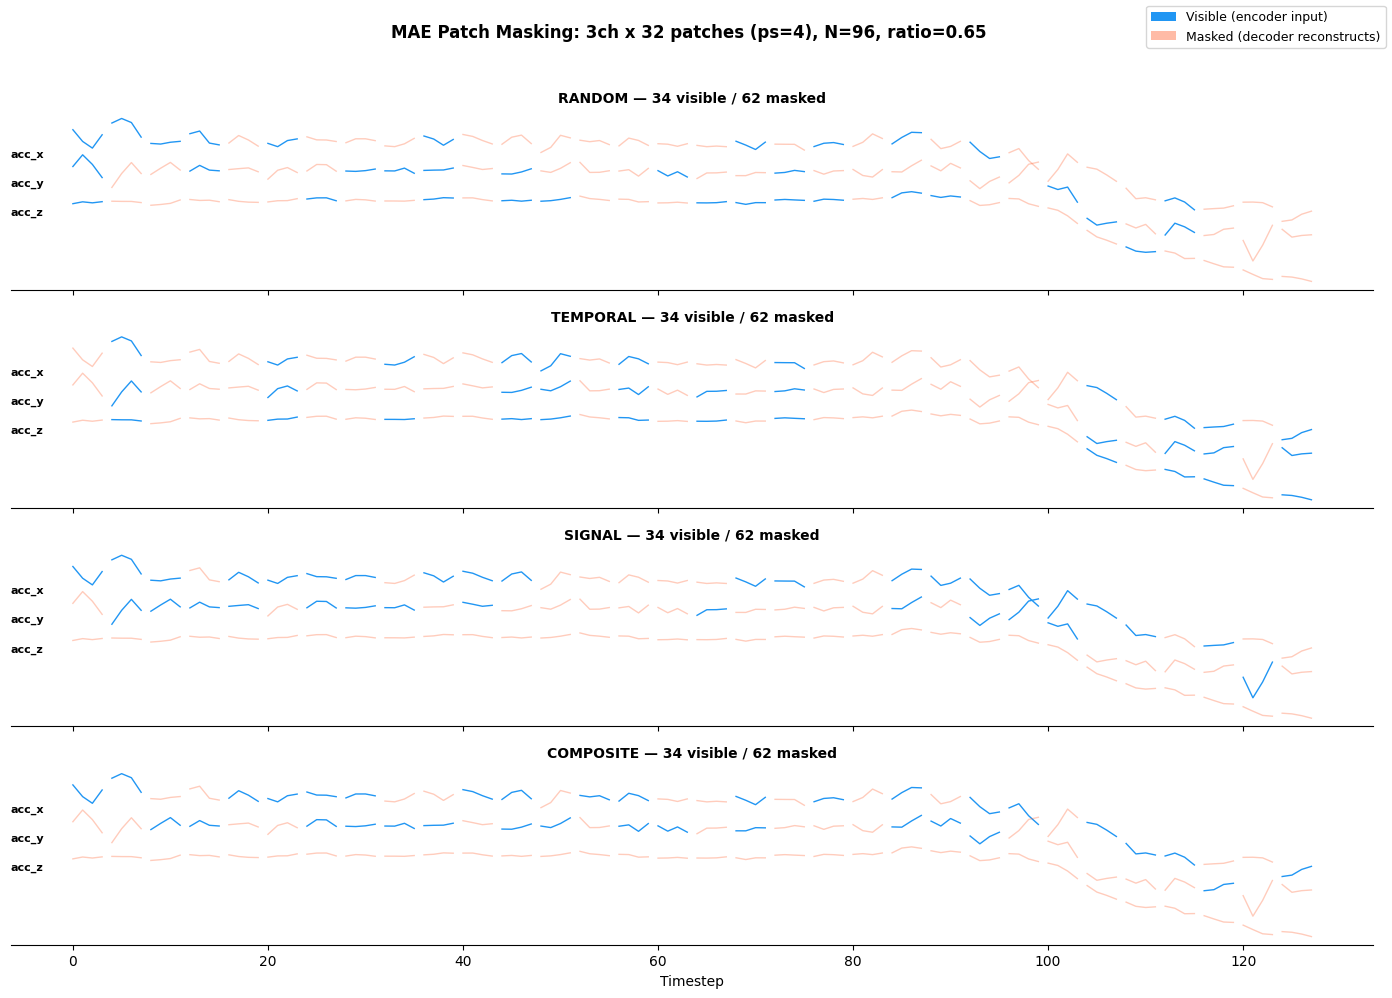


Token layout: 3 channels x 32 patches/ch = 96 total tokens
Mask ratio: 0.65 -> 62 masked, 34 visible
Encoder sees ONLY the 34 blue patches — no zeros, no placeholders
Decoder inserts learnable mask tokens at 62 positions and reconstructs


In [2]:
# Visualize MAE patch-level masking (LSM-2 style composite strategy)
# Shows what the encoder sees (visible patches) vs what decoder must reconstruct (masked patches)
# Uses the actual WindowDataset + data loaders from configs/base.yaml

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import pandas as pd
import pyarrow.dataset as ds

from imu_lm.utils.helpers import load_yaml, cfg_get, deep_update
from imu_lm.data.windowing import compute_T_and_hop
from imu_lm.data.loaders import WindowDataset, _make_loader
from imu_lm.data.splits import SessionKey
from imu_lm.objectives.masked_1d import generate_patch_mask

# Load configs (base + vit1d for patch_size)
cfg = deep_update(load_yaml("configs/base.yaml"), load_yaml("configs/vit1d.yaml"))
parquet_path = cfg_get(cfg, ["paths", "dataset_path"])
sensor_cols = cfg_get(cfg, ["data", "sensor_columns"], [])
dataset_col = cfg_get(cfg, ["data", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "session_column"], "session_id")

# Find one SAMoSA session
pa_ds = ds.dataset(parquet_path, format="parquet")
filt = ds.field(dataset_col) == "samosa"
scanner = pa_ds.scanner(columns=[dataset_col, subject_col, session_col], batch_size=10000, filter=filt)
key = None
for batch in scanner.to_batches():
    if len(batch) > 0:
        key = SessionKey(
            dataset=str(batch[dataset_col][0].as_py()),
            subject_id=str(batch[subject_col][0].as_py()),
            session_id=str(batch[session_col][0].as_py()),
        )
        break
assert key is not None, "No samosa sessions found"

# Count rows for session index
filt2 = (ds.field(dataset_col) == key.dataset) & (ds.field(subject_col) == key.subject_id) & (ds.field(session_col) == key.session_id)
n_rows = pa_ds.scanner(filter=filt2).count_rows()

session_index = pd.DataFrame([{
    "dataset": key.dataset, "subject_id": key.subject_id,
    "session_id": key.session_id, "n_rows": n_rows, "gap_count": 0,
}])

# Build real WindowDataset (applies preprocess + augmentation)
dataset = WindowDataset(parquet_path, session_index, [key], cfg, split_name="masking_viz")
loader = _make_loader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
x, y = next(iter(loader))  # x: [1, C, T]
x = x.squeeze(0)  # [C, T]
C, T_actual = x.shape
print(f"Window shape: [{C}, {T_actual}] from session {key}")

# Masking config
patch_size = int(cfg_get(cfg, ["vit1d", "patch_size"], 4))
mask_ratio = float(cfg_get(cfg, ["objective", "mask_ratio"], 0.75))
npc = T_actual // patch_size
N = C * npc

# Generate masks for all 3 strategies + composite
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
strategies = ["random", "temporal", "signal", "composite"]
vis_color, mask_color = "#2196F3", "#FF5722"

for ax_idx, strat in enumerate(strategies):
    ax = axes[ax_idx]
    mask = generate_patch_mask(1, npc, C, mask_ratio, strat, torch.device("cpu"))
    mask_2d = mask[0].view(C, npc).numpy()

    n_masked = int(mask[0].sum())
    n_visible = N - n_masked
    signal = x.numpy()

    for c in range(C):
        y_offset = (C - 1 - c) * 1.2
        for p in range(npc):
            t_start = p * patch_size
            t_end = t_start + patch_size
            t_range = np.arange(t_start, t_end)
            is_masked = mask_2d[c, p]
            color = mask_color if is_masked else vis_color
            alpha = 0.3 if is_masked else 1.0
            ax.plot(t_range, signal[c, t_start:t_end] + y_offset, color=color, alpha=alpha, linewidth=1.0)
        ax.text(-3, y_offset, sensor_cols[c], ha="right", va="center", fontsize=8, fontweight="bold")

    ax.set_title(f"{strat.upper()} — {n_visible} visible / {n_masked} masked", fontsize=10, fontweight="bold")
    ax.set_yticks([])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)

axes[-1].set_xlabel("Timestep", fontsize=10)
legend_elements = [
    mpatches.Patch(facecolor=vis_color, label="Visible (encoder input)"),
    mpatches.Patch(facecolor=mask_color, alpha=0.4, label="Masked (decoder reconstructs)"),
]
fig.legend(handles=legend_elements, loc="upper right", fontsize=9)
fig.suptitle(f"MAE Patch Masking: {C}ch x {npc} patches (ps={patch_size}), N={N}, ratio={mask_ratio}", fontsize=12, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"\nToken layout: {C} channels x {npc} patches/ch = {N} total tokens")
print(f"Mask ratio: {mask_ratio} -> {n_masked} masked, {n_visible} visible")
print(f"Encoder sees ONLY the {n_visible} blue patches — no zeros, no placeholders")
print(f"Decoder inserts learnable mask tokens at {n_masked} positions and reconstructs")

In [ ]:
# Dataset suitability for probing — subjects, sessions, classes, label balance
# Streams batches via pyarrow scanner — never materializes full table (capture24 = 699M rows)
import pyarrow.dataset as ds
import pyarrow.compute as pc
from collections import defaultdict
import gc

parquet_path = "/home/aidan/TransfHAR/imu_lm/data/data_drive/IMULM_master_dataset.parquet"
dset = ds.dataset(parquet_path, format="parquet")

# Accumulate per-dataset stats via streaming batches (constant memory)
subjects = defaultdict(set)
sessions = defaultdict(set)
label_counts = defaultdict(lambda: defaultdict(int))
row_counts = defaultdict(int)

cols = ["dataset", "subject_id", "session_id", "dataset_activity_id"]
scanner = dset.scanner(columns=cols, batch_size=1_000_000)

print("Streaming (batch_size=1M)...")
n = 0
for batch in scanner.to_batches():
    n += len(batch)
    if n % 50_000_000 < 1_000_000:
        print(f"  {n:,} rows...", flush=True)
    # Process in pyarrow: group by dataset within this batch
    ds_arr = batch["dataset"]
    subj_arr = batch["subject_id"]
    sess_arr = batch["session_id"]
    lbl_arr = batch["dataset_activity_id"]
    # Get unique datasets in this batch to avoid per-row Python loop
    unique_ds = pc.unique(ds_arr).to_pylist()
    for d in unique_ds:
        mask = pc.equal(ds_arr, d)
        row_counts[d] += pc.sum(mask.cast("int64")).as_py()
        subjects[d].update(pc.filter(subj_arr, mask).unique().to_pylist())
        sessions[d].update(pc.filter(sess_arr, mask).unique().to_pylist())
        for entry in pc.filter(lbl_arr, mask).value_counts().to_pylist():
            label_counts[d][entry["values"]] += entry["counts"]
    del batch; gc.collect()

print(f"Done: {n:,} rows total\n")

print(f"{'Dataset':20s} {'Subj':>5s} {'Sess':>5s} {'Cls':>5s} {'Rows':>12s} {'Balance':>8s}  Verdict")
print("-" * 75)

for name in sorted(row_counts):
    n_subj = len(subjects[name])
    n_sess = len(sessions[name])
    counts = label_counts[name]
    n_cls = len(counts)
    vals = list(counts.values())
    bal = min(vals) / max(vals) if len(vals) > 1 else 0.0

    flags = []
    if n_subj < 5:   flags.append("few subjects")
    if n_cls < 3:     flags.append("few classes")
    if n_cls > 50:    flags.append("sparse classes")
    if bal < 0.05 and n_cls > 1: flags.append("imbalanced")
    verdict = ", ".join(flags) if flags else "GOOD"

    print(f"{name:20s} {n_subj:5d} {n_sess:5d} {n_cls:5d} {row_counts[name]:12,} {bal:8.3f}  {verdict}")

print("\nGood probe = >=5 subjects, 5-30 classes, balance > 0.1")

In [2]:
# Dataset suitability for probing — subjects, sessions, classes, label balance
# Uses pyarrow groupby/aggregate to avoid materializing 734M rows in Python
import pyarrow.dataset as ds
import pyarrow.compute as pc

parquet_path = "/home/aidan/TransfHAR/imu_lm/data/data_drive/IMULM_master_dataset.parquet"
dset = ds.dataset(parquet_path, format="parquet")

# Get dataset names from cell 5 output (avoids re-scanning just for names)
all_datasets = sorted([
    "opportunity++", "pamap2", "prism", "recofit",
    "samosa", "shoaib", "ut_watch", "wear", "wisdm"
])

print(f"{'Dataset':20s} {'Subj':>5s} {'Sess':>5s} {'Cls':>5s} {'Rows':>12s} {'Balance':>8s}  Verdict")
print("-" * 75)

for name in all_datasets:
    print(f"  scanning {name}...", end="", flush=True)
    filt = ds.field("dataset") == name

    # Count rows
    n_rows = dset.scanner(filter=filt).count_rows()

    # Unique subjects — use scanner to get just subject_id, then unique in pyarrow
    subj_col = dset.to_table(columns=["subject_id"], filter=filt)["subject_id"]
    n_subj = pc.count_distinct(subj_col).as_py()

    # Unique sessions
    sess_col = dset.to_table(columns=["session_id"], filter=filt)["session_id"]
    n_sess = pc.count_distinct(sess_col).as_py()

    # Label distribution — value_counts in pyarrow
    label_col = dset.to_table(columns=["dataset_activity_id"], filter=filt)["dataset_activity_id"]
    n_cls = pc.count_distinct(label_col).as_py()
    vc = label_col.value_counts()
    counts = [entry["values"].as_py() for entry in vc.to_pylist()]  # actually need the counts
    count_vals = [entry["counts"] for entry in vc.to_pylist()]
    if len(count_vals) > 1:
        bal = min(count_vals) / max(count_vals)
    else:
        bal = 0.0

    flags = []
    if n_subj < 5:   flags.append("few subjects")
    if n_cls < 3:     flags.append("few classes")
    if n_cls > 50:    flags.append("sparse classes")
    if bal < 0.05 and n_cls > 1: flags.append("imbalanced")
    verdict = ", ".join(flags) if flags else "GOOD"

    print(f"\r{name:20s} {n_subj:5d} {n_sess:5d} {n_cls:5d} {n_rows:12,} {bal:8.3f}  {verdict}")

print("\nGood probe = >=5 subjects, 5-30 classes, balance > 0.1")

Dataset               Subj  Sess   Cls         Rows  Balance  Verdict
---------------------------------------------------------------------------
  scanning opportunity++...

AttributeError: 'int' object has no attribute 'as_py'

In [ ]:
# Comparison: Our ViT1D MAE Linear Probe vs SAMoSA Paper (Motion-only baseline)

import numpy as np
import matplotlib.pyplot as plt

ours = {
    "Balanced Acc.": 56.70,
    "Macro F1": 55.42,
    "Macro Prec.": 56.47,
    "Macro Recall": 56.70,
}

samosa = {
    "Balanced Acc.": 78.8,
    "Macro F1": 76.5,
    "Macro Prec.": 75.0,
    "Macro Recall": 78.8,
}

metrics = list(ours.keys())
ours_vals = [ours[m] for m in metrics]
samosa_vals = [samosa[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(x - width/2, ours_vals, width, label="ViT1D-MAE Linear Probe (Ours)", edgecolor="white")
bars2 = ax.bar(x + width/2, samosa_vals, width, label="SAMoSA Motion-only CNN", edgecolor="white")

# Add value labels inside bars
for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h/2, f"{h:.1f}%",
            ha="center", va="center", fontsize=10, fontweight="bold", color="white")
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h/2, f"{h:.1f}%",
            ha="center", va="center", fontsize=10, fontweight="bold", color="white")

ax.set_ylabel("Score (%)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 100)
ax.legend(frameon=True, edgecolor="lightgray")
ax.grid(axis="y", alpha=0.3, linewidth=0.5)
ax.set_axisbelow(True)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig("probe_vs_samosa_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Check subject/class/session counts for candidate second probe datasets
import pyarrow.dataset as ds, pyarrow.compute as pc

parquet_path = "/home/aidan/TransfHAR/imu_lm/data/data_drive/IMULM_master_dataset.parquet"
dset = ds.dataset(parquet_path, format="parquet")

candidates = ["opportunity++", "wisdm", "wear", "prism", "capture24"]
print(f"{'Dataset':20s} {'Subjects':>8s} {'Sessions':>8s} {'Classes':>8s} {'Rows':>12s}")
print("-" * 60)
for name in candidates:
    t = dset.to_table(
        columns=["dataset", "subject_id", "session_id", "dataset_activity_id"],
        filter=ds.field("dataset") == name,
    )
    subj = len(pc.unique(t["subject_id"]).to_pylist())
    sess = len(pc.unique(t["session_id"]).to_pylist())
    cls = len(pc.unique(t["dataset_activity_id"]).to_pylist())
    print(f"{name:20s} {subj:8d} {sess:8d} {cls:8d} {len(t):12,}")
